# **612 Final Project**

**Group members**: Rick Zhang, Cory Wu, Lucien Somorai, Warisa Khaophong, Bo Zheng Ma


**Data Set**: New York Taxi Trip Data

**Source**: [Kaggle](https://www.kaggle.com/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019/)

**Question**: Given the time, pickup location, and drop-off location, predict the total amount for the trip.

**Reason for Question Choice**: Companies like Uber and Lyft often allow users to book and pay for trips in advance. This enables them to collect fare upfront, optimize traffic predictions, and allocate resources effectively.

##Data Processing

###Initialize Spark

In [ ]:
#start a pyspark session -- Google Gemini Was used to Generate Code of initializing Spark

# Install PySpark if it's not already installed
!pip install pyspark==3.5.3

# PyArrow may be needed to be installed
!pip install PyArrow

# Import SparkSession
from pyspark.sql import SparkSession

#spark.stop()

# Create a SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

# Verify that the session is active
spark


In [ ]:
# Create a simple DataFrame to verify that Spark is working
data = [("John", 30), ("Alice", 25), ("Bob", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()

+-----+---+
| Name|Age|
+-----+---+
| John| 30|
|Alice| 25|
|  Bob| 35|
+-----+---+



Spark is working!

###Import Data

Please add the submmited 'yellow_tripdata_2019-06.csv' to files.

Set the notebook to only import 1% of the file. Otherwise data processing and model training will take too long.

Data Source: Newyork Taxi Trip Data
https://www.kaggle.com/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019/


In [ ]:
df = spark.read.csv("/content/yellow_tripdata_2019-06.csv", header=True, inferSchema=True) \
    .sample(withReplacement=False, fraction=0.01, seed=42)

#Inspect data after import
df.head(5)

[Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2019, 6, 1, 0, 2, 40), tpep_dropoff_datetime=datetime.datetime(2019, 6, 1, 0, 18, 37), passenger_count=1, trip_distance=2.0, RatecodeID=1, store_and_fwd_flag='N', PULocationID=162, DOLocationID=68, payment_type=1, fare_amount=11.5, extra=3.0, mta_tax=0.5, tip_amount=2.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=17.3, congestion_surcharge=2.5),
 Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2019, 6, 1, 0, 22, 43), tpep_dropoff_datetime=datetime.datetime(2019, 6, 1, 0, 27, 27), passenger_count=1, trip_distance=1.53, RatecodeID=1, store_and_fwd_flag='N', PULocationID=48, DOLocationID=239, payment_type=1, fare_amount=6.5, extra=0.5, mta_tax=0.5, tip_amount=2.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=12.3, congestion_surcharge=2.5),
 Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2019, 6, 1, 0, 21), tpep_dropoff_datetime=datetime.datetime(2019, 6, 1, 0, 30, 49), passenger_count=1, tr

In [ ]:
#print all columns names
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge']

 Column Name:

 1. 'VendorID'  TPEP Provider ID 1 or 2, not used in this project
 2. 'tpep_pickup_datetime'  Pickup date and time
 3. 'tpep_dropoff_datetime'  Dropoff date and time
 4. 'passenger_count'  Number of passengers
 5. 'trip_distance'  Trip distance in miles
 6. 'RatecodeID'  Rate code ID: 1=Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride
 7. 'store_and_fwd_flag'  Store and forward flag, not used in this project
 8. 'PULocationID'  Pickup location ID
 9. 'DOLocationID'  Dropoff location ID
 10. 'payment_type'  Payment type: 1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown, 6=Voided trip
 11. 'fare_amount'  Fare amount
 12. 'extra'  Extra charges
 13. 'mta_tax'  MTA tax
 14. 'tip_amount'  Tip amount
 15. 'tolls_amount'  Tolls amount
 16. 'improvement_surcharge'  Improvement surcharge
 17. 'total_amount'  Total amount
 18. 'congestion_surcharge'  Congestion surcharge


###Inspect Data

In [ ]:
# Print the schema (column names and types)
df.printSchema()

# Get number of rows
print("Number of rows:", df.count())

# Show basic statistics for numeric columns
df.describe().show()

# Show the first few rows
df.show(5)

# Get column names
print("Columns:", df.columns)

# Get basic data types of columns
for col in df.columns:
    print(f"{col}: {df.schema[col].dataType}")

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

Number of rows: 69841
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+----

Drop non-informative columns.

In [ ]:
# Drop specified columns
df_cleaned = df.drop(
    'VendorID',
    'store_and_fwd_flag',
    'fare_amount',
    'extra',
    'mta_tax',
    'tolls_amount',
    'improvement_surcharge',
    'congestion_surcharge',
    'payment_type',
    'tip_amount'
)

# Verify the remaining columns
print("Remaining columns:", df_cleaned.columns)

# Show a few rows of the cleaned dataset
df_cleaned.show(5)

Remaining columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'total_amount']
+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|total_amount|
+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+
| 2019-06-01 00:02:40|  2019-06-01 00:18:37|              1|          2.0|         1|         162|          68|        17.3|
| 2019-06-01 00:22:43|  2019-06-01 00:27:27|              1|         1.53|         1|          48|         239|        12.3|
| 2019-06-01 00:21:00|  2019-06-01 00:30:49|              1|          1.5|         1|         148|          87|        13.8|
| 2019-06-01 00:39:45|  2019-06-01 00:48:40|              1|         1.28|         

Join the table with locaiton name table to show location name instead of location id.

In [ ]:
# for better machine learning result, replace pullocationID and dolocationID with location name

df_zone_name = spark.read.csv('taxi+_zone_lookup.csv', header=True, inferSchema=True)
df_zone_name = df_zone_name.drop('Borough', 'service_zone')
df_zone_name.show(5)


+----------+--------------------+
|LocationID|                Zone|
+----------+--------------------+
|         1|      Newark Airport|
|         2|         Jamaica Bay|
|         3|Allerton/Pelham G...|
|         4|       Alphabet City|
|         5|       Arden Heights|
+----------+--------------------+
only showing top 5 rows



In [ ]:
# Use RDD to perform a mapreduce
# Convert location mapping to dictionary
location_dict = dict(df_zone_name.select("LocationID", "Zone").rdd.collect())

# Create broadcast variable for the mapping
location_broadcast = spark.sparkContext.broadcast(location_dict)

# Define map functions
def map_locations(row):
    locations = location_broadcast.value
    # Map both pickup and dropoff locations
    pu_location = locations.get(row.PULocationID, "Unknown")
    do_location = locations.get(row.DOLocationID, "Unknown")

    return (
        row.tpep_pickup_datetime,
        row.tpep_dropoff_datetime,
        row.passenger_count,
        row.trip_distance,
        row.RatecodeID,
        pu_location,  # Replaced PULocationID
        do_location,  # Replaced DOLocationID
        row.total_amount
    )

# Apply the transformation

# 1. Convert DataFrame to RDD
rdd = df_cleaned.rdd

# 2. Apply the mapping function
mapped_rdd = rdd.map(map_locations)

# 3. Define the schema (column names for the new DataFrame)
new_column_names = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'passenger_count',
    'trip_distance',
    'RatecodeID',
    'pickup_location',
    'dropoff_location',
    'total_amount'
]

# 4. Convert back to DataFrame with the new schema
df_mapped = mapped_rdd.toDF(new_column_names)

# Show results
df_mapped.show(5)

+--------------------+---------------------+---------------+-------------+----------+--------------------+--------------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+--------------------+---------------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01 00:02:40|  2019-06-01 00:18:37|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01 00:22:43|  2019-06-01 00:27:27|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01 00:21:00|  2019-06-01 00:30:49|              1|          1.5|         1|     Lower East Side|Financial Distric...|        13.8|
| 2019-06-01 00:39:45|  2019-06-01 00:48:40|              1|         1.28|         1|Greenwich Village...|           Hudson Sq|       13.56|
| 2019-06-01 

Format Date and Time

In [ ]:
from pyspark.sql.functions import hour, to_date

# Create new DataFrame with extracted date and hour
df_time_processed = df_mapped \
    .withColumn('pickup_date', to_date('tpep_pickup_datetime')) \
    .withColumn('pickup_hour', hour('tpep_pickup_datetime')) \
    .withColumn('dropoff_date', to_date('tpep_dropoff_datetime')) \
    .withColumn('dropoff_hour', hour('tpep_dropoff_datetime')) \
    .drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')

# Reorder columns for better readability
columns_order = [
    'pickup_date',
    'pickup_hour',
    'dropoff_date',
    'dropoff_hour',
    'passenger_count',
    'trip_distance',
    'RatecodeID',
    'pickup_location',
    'dropoff_location',
    'total_amount'
]

df_time_processed = df_time_processed.select(columns_order)

# Show the result
df_time_processed.show(5)

+-----------+-----------+------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_hour|dropoff_date|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+-----------+------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          0|  2019-06-01|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          0|  2019-06-01|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          0|  2019-06-01|           0|              1|          1.5|         1|     Lower East Side|Financial Distric...|        13.8|
| 2019-06-01|          0|  2019-06-01|           0|              1|         1.28|         1|Greenwich Village...

Add week day.

In [ ]:
from pyspark.sql.functions import date_format, dayofweek

# Add day of week (1 = Sunday, 7 = Saturday)
df_with_dow = df_time_processed \
    .withColumn('pickup_day_of_week', date_format('pickup_date', 'EEEE')) \
    .withColumn('dropoff_day_of_week', date_format('dropoff_date', 'EEEE'))



# Reorder columns
columns_order = [
    'pickup_date',
    'pickup_day_of_week',
    'pickup_hour',
    'dropoff_date',
    'dropoff_day_of_week',
    'dropoff_hour',
    'passenger_count',
    'trip_distance',
    'RatecodeID',
    'pickup_location',
    'dropoff_location',
    'total_amount'
]

df_with_dow = df_with_dow.select(columns_order)

# Show the result
from pyspark.storagelevel import StorageLevel
#df_with_dow.persist(StorageLevel.MEMORY_ONLY)
df_with_dow.cache()
df_with_dow.show(5)

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

Output Processed Data

In [ ]:
df_with_dow.coalesce(1).write.csv('df_with_dow.csv', header=True, mode='overwrite')

Folder df_with_dow.csv is created to store the processed data.

### Correlation Matrix

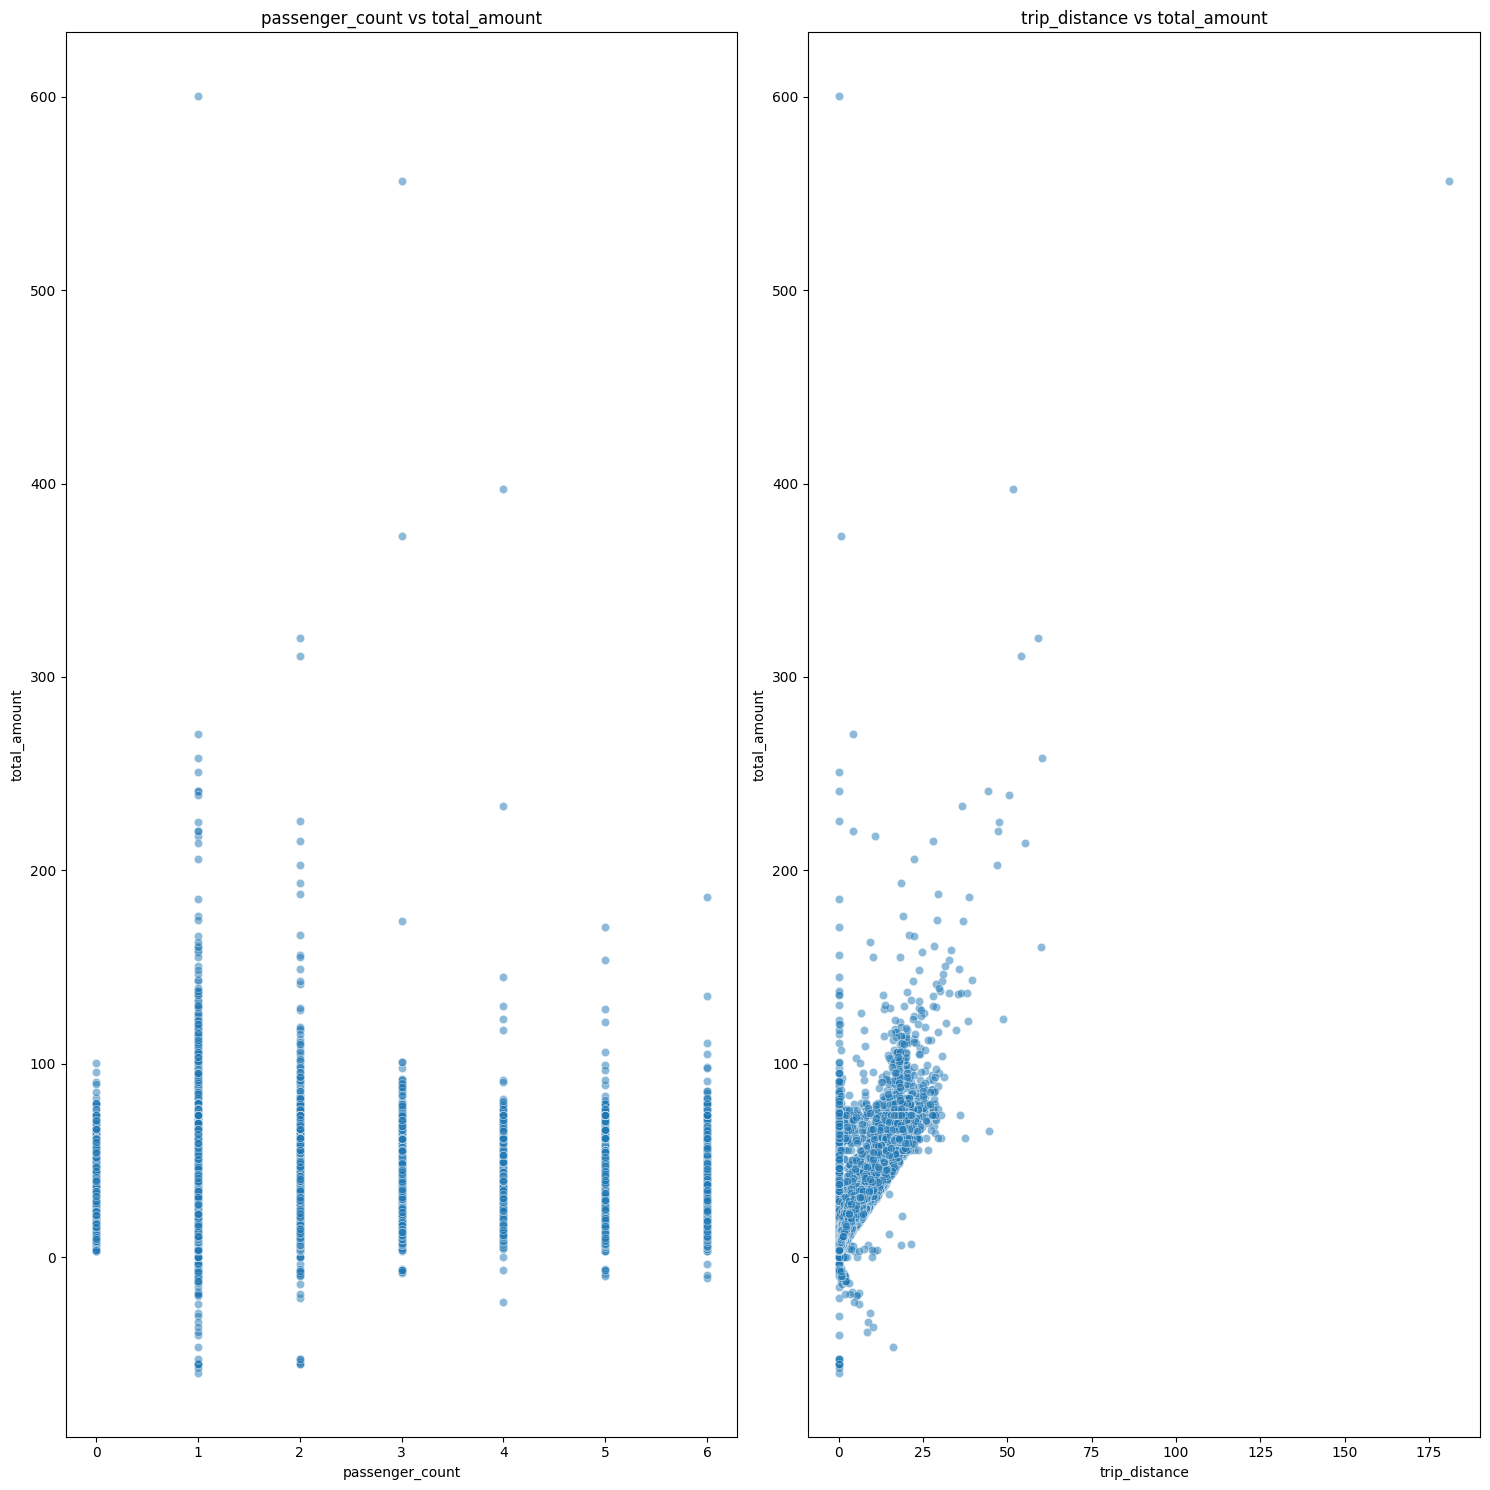

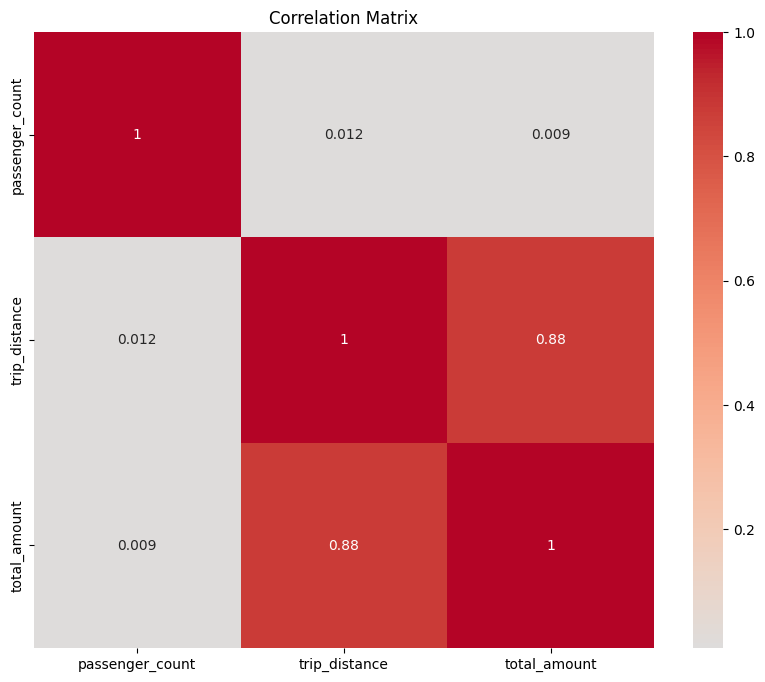

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
# Select only numerical columns that make sense for correlation
pdf = df_with_dow.select([
    'passenger_count',
    'trip_distance',
    'total_amount'
]).toPandas()

# Create subplots for each feature vs target
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes = axes.ravel()

features = ['passenger_count', 'trip_distance']

for idx, feature in enumerate(features):
    sns.scatterplot(data=pdf, x=feature, y='total_amount', ax=axes[idx], alpha=0.5)
    axes[idx].set_title(f'{feature} vs total_amount')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('total_amount')

plt.tight_layout()
plt.show()

# Optional: Show correlation matrix
correlation_matrix = pdf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows trip_distance affects total_amount the most.

## Machine Learning

### 1. SVM

Import Pre-processed Data <br>
Recommend to use the submitted processed_data.csv<br>

or<br>
<br>
Use the csv file in df_with_dow folder

In [ ]:
# Change to the correct file path
df = spark.read.csv("/content/processed_data.csv", header=True, inferSchema=True)
df.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

Train Support Vector Machine Model and plot the result. This will take about 30s. <br>
Tested grid search and cross validation in this part.

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Grid Search Results:
Best C value: 0.5
Best R² score: 0.811


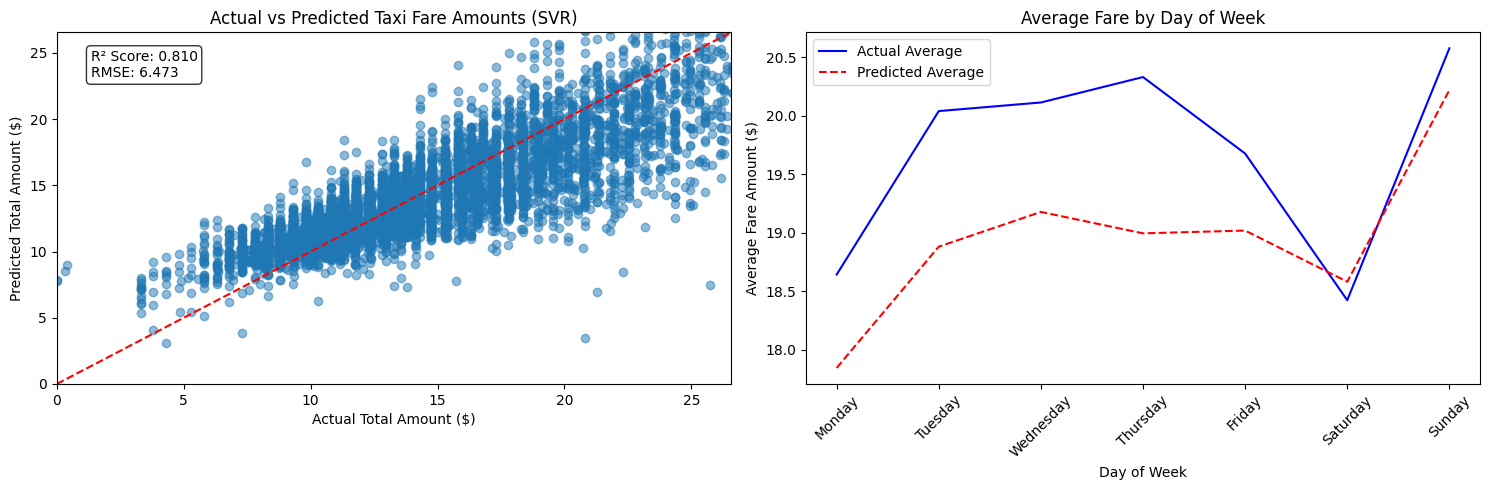


Feature Importances (SVR Coefficients):
trip_distance: 14.1501
dropoff_location_idx: 0.7476
pickup_hour: 0.3172
day_sin: 0.2686
pickup_location_idx: 0.2410
day_cos: 0.1243
passenger_count: 0.0104


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col, sin, cos, pandas_udf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Sample 10% of the data and cache it
df_SVM = df.sample(fraction=0.1, seed=42).cache()

# Drop existing indexed columns if they exist
columns_to_drop = ["day_number", "day_sin", "day_cos",
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df_SVM.columns:
        df_SVM = df_SVM.drop(col_name)

# Create temporal features
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df_SVM = day_indexer.fit(df_SVM).transform(df_SVM)

# Create cyclic features
df_SVM = df_SVM.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df_SVM = df_SVM.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df_SVM = location_indexer.fit(df_SVM).transform(df_SVM)

dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df_SVM = dropoff_indexer.fit(df_SVM).transform(df_SVM)


# Feature assembly with temporal features
assembler = VectorAssembler(
    inputCols=["pickup_hour", "day_sin", "day_cos",
               "passenger_count", "trip_distance",
               "pickup_location_idx", "dropoff_location_idx"],
    outputCol="features",
    handleInvalid="skip"
)
data = assembler.transform(df_SVM).cache()

# Train SVR model with smaller batch
train_sample = data.limit(10000)
features_rdd = train_sample.select("features").rdd.map(lambda row: row[0].toArray())
X = np.array(features_rdd.collect())
y = np.array(train_sample.select("total_amount").collect()).ravel()

# Create pipeline with StandardScaler and SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear', cache_size=1000))
])

# Define parameter grid
param_grid = {
    'svr__C': [0.5, 1.0]
}

# Create and run GridSearchCV
grid_search = GridSearchCV(
    svr_pipeline,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X, y)

# Print grid search results
print("\nGrid Search Results:")
print(f"Best C value: {grid_search.best_params_['svr__C']}")
print(f"Best R² score: {grid_search.best_score_:.3f}")

# Get the best model
best_model = grid_search.best_estimator_

# Modified prediction UDF to use the pipeline
@pandas_udf(DoubleType())
def svr_predict(features):
    try:
        X = np.vstack([np.fromstring(f[1:-1], sep=',') for f in features])
        return pd.Series(best_model.predict(X))
    except Exception as e:
        print(f"Error in prediction: {e}")
        return pd.Series([None] * len(features))



# Transform data and add predictions
data = assembler.transform(df_SVM)
data = data.withColumn("features_str", col("features").cast("string"))
predictions = data.withColumn("prediction", svr_predict(col("features_str")))

# Calculate metrics
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")
r2 = evaluator.setMetricName("r2").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)

# Create visualizations
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Plot
plt.subplot(1, 2, 1)
pred_pd = predictions.select("total_amount", "prediction").toPandas()

max_value = max(pred_pd["total_amount"].max(), pred_pd["prediction"].max())
axis_limit = 0.2 * max_value

plt.scatter(pred_pd["total_amount"], pred_pd["prediction"], alpha=0.5)
plt.plot([0, axis_limit], [0, axis_limit], 'r--')
plt.xlim(0, axis_limit)
plt.ylim(0, axis_limit)

plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (SVR)")

metrics_text = f'R² Score: {r2:.3f}\nRMSE: {rmse:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg = predictions.groupBy("pickup_day_of_week").agg(
    {"total_amount": "avg", "prediction": "avg"}
).toPandas()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.set_index('pickup_day_of_week').reindex(days_order)

plt.plot(day_avg.index, day_avg['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg.index, day_avg['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week")
plt.legend()

plt.tight_layout()
plt.show()

# Feature importances
svr_model = best_model.named_steps['svr']  # Extract SVR from pipeline
if hasattr(svr_model, 'coef_'):
    feature_names = ["pickup_hour", "day_sin", "day_cos",
                    "passenger_count", "trip_distance",
                    "pickup_location_idx", "dropoff_location_idx"]
    importances = [(feature, abs(coef)) for feature, coef in zip(feature_names, svr_model.coef_[0])]
    importances.sort(key=lambda x: x[1], reverse=True)
    print("\nFeature Importances (SVR Coefficients):")
    for feature, importance in importances:
        print(f"{feature}: {importance:.4f}")

Performance of SVM model is good with R2 Socre = 0.810 and RMSE=6.473.

### 2. Ridge Regression

In [ ]:
# import df_with_dow.csv/part-00000-2bd45c6f-2cf2-4333-81d8-96431e4c7041-c000.csv
df_RR = spark.read.csv("/content/processed_data.csv", header=True, inferSchema=True)
df_RR.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

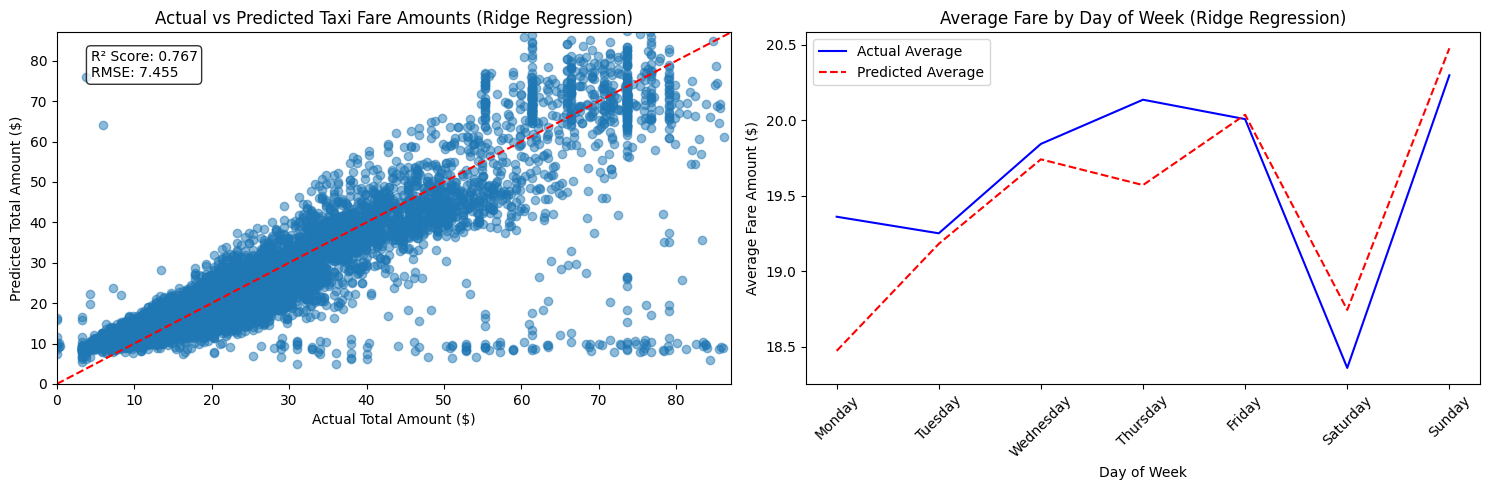


Feature Importances:
trip_distance: 3.4188
day_sin: 0.6546
day_cos: 0.3654
pickup_hour: 0.0596
dropoff_location_idx: 0.0239
pickup_location_idx: 0.0113
passenger_count: 0.0085


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col, sin, cos, lit, radians

# Drop existing indexed columns if they exist
columns_to_drop = ["day_number", "day_sin", "day_cos",
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df_RR.columns:
        df_RR = df_RR.drop(col_name)

# Create day number (0-6)
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df_RR = day_indexer.fit(df_RR).transform(df_RR)

# Create cyclic features for days
df_RR = df_RR.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df_RR = df_RR.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns to numeric
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df_RR = location_indexer.fit(df_RR).transform(df_RR)
dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df_RR = dropoff_indexer.fit(df_RR).transform(df_RR)

# Assembler remains the same
assembler = VectorAssembler(
    inputCols=["pickup_hour", "day_sin", "day_cos", "passenger_count",
               "trip_distance", "pickup_location_idx", "dropoff_location_idx"],
    outputCol="features"
)
data_RR = assembler.transform(df_RR)

# Split the data into training and testing sets
train_data, test_data = data_RR.randomSplit([0.7, 0.3], seed=42)

# Create and train the Ridge Regression model
# Note: RidgeRegression in PySpark is implemented through LinearRegression with an elasticNetParam of 0
ridge = LinearRegression(
    maxIter=10,
    regParam=0.1,
    elasticNetParam=0.0,  # L2 regularization (Ridge)
    featuresCol="features",
    labelCol="total_amount"
)
model_ridge = ridge.fit(train_data)
predictions_ridge = model_ridge.transform(test_data)

# Create visualizations (same as before)
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Plot
plt.subplot(1, 2, 1)

# Calculate the max value for axis limits (80% of maximum)
pred_ridge = predictions_ridge.select("total_amount", "prediction").toPandas()
max_value = max(pred_ridge["total_amount"].max(), pred_ridge["prediction"].max())
axis_limit = 0.2 * max_value

# Create scatter plot with modified axes
plt.scatter(pred_ridge["total_amount"], pred_ridge["prediction"], alpha=0.5)
plt.plot([0, axis_limit], [0, axis_limit], 'r--')
plt.xlim(0, axis_limit)
plt.ylim(0, axis_limit)
plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (Ridge Regression)")
metrics_text = f'R² Score: {model_ridge.summary.r2:.3f}\nRMSE: {model_ridge.summary.rootMeanSquaredError:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg = predictions_ridge.groupBy("pickup_day_of_week").agg({"total_amount": "avg", "prediction": "avg"}).toPandas()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.set_index('pickup_day_of_week').reindex(days_order)
plt.plot(day_avg.index, day_avg['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg.index, day_avg['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week (Ridge Regression)")
plt.legend()
plt.tight_layout()
plt.show()

# Print feature importances
feature_names = ["pickup_hour", "day_sin", "day_cos", "passenger_count",
                "trip_distance", "pickup_location_idx", "dropoff_location_idx"]
importances = [(feature, abs(importance)) for feature, importance in zip(feature_names, model_ridge.coefficients)]
importances.sort(key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature}: {importance:.4f}")

The performance of Reidge Regression is OK with R2 socre=0.767 and RMSE=7.455.

###3. Random Forest


In [ ]:
df_RF = spark.read.csv("/content/processed_data.csv", header=True, inferSchema=True)
df_RF.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

This part will take about 5min to run.

Best Model Parameters: {Param(parent='RandomForestRegressor_bee20244ffad', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestRegressor_bee20244ffad', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestRegressor_bee20244ffad', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestRegressor_bee20244ffad', name='featureSubsetStrategy', doc="The number of features to consider for splits at each

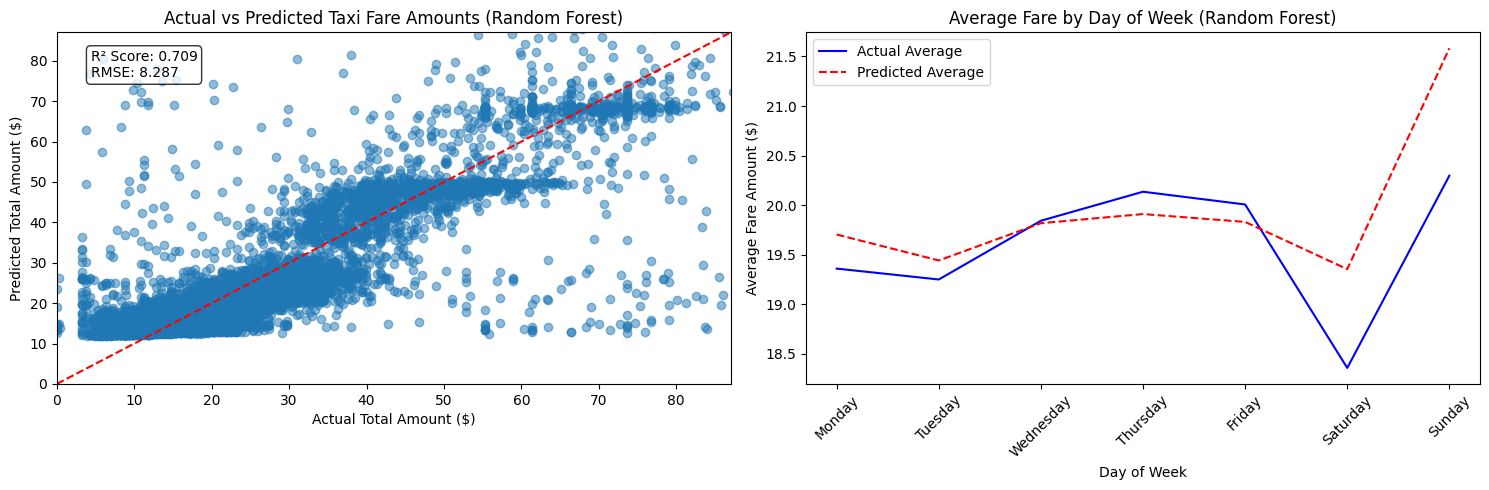


Feature Importances (Random Forest):
trip_distance: 0.6035
pickup_location_idx: 0.2023
dropoff_location_idx: 0.1863
pickup_hour: 0.0041
passenger_count: 0.0015
day_cos: 0.0013
day_sin: 0.0010


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Drop existing indexed columns in case they exist
columns_to_drop = ["day_number", "day_sin", "day_cos",
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df_RF.columns:
        df_RF = df_RF.drop(col_name)

# Create day number, start from counting from 0. Range 0-6
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df_RF = day_indexer.fit(df_RF).transform(df_RF)

# Create cyclic features for days
df_RF = df_RF.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df_RF = df_RF.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df_RF = location_indexer.fit(df_RF).transform(df_RF)

dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df_RF = dropoff_indexer.fit(df_RF).transform(df_RF)

assembler = VectorAssembler(
    inputCols=["pickup_hour", "day_sin", "day_cos", "passenger_count",
               "trip_distance", "pickup_location_idx", "dropoff_location_idx"],
    outputCol="features"
)
data_rf = assembler.transform(df_RF)

# Split
train_rf, test_rf = data_rf.randomSplit([0.7, 0.3], seed=42)

# Define RF Regressor. I had to increase the maxBins, otherwise it struggles
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount", maxDepth=10, maxBins=256, seed=42)
# Evaluator
evaluator_rf = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")

# Param Grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

# Cross validate
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=3,
                             seed=42)

# Fit model
cvModel_rf = crossval_rf.fit(train_rf)

# Output the best model parameters
bestModel_rf = cvModel_rf.bestModel
print("Best Model Parameters:", bestModel_rf.extractParamMap())

# Predictions
predictions_rf = bestModel_rf.transform(test_rf)

# Metrics
r2_rf = evaluator_rf.setMetricName("r2").evaluate(predictions_rf)
rmse_rf = evaluator_rf.setMetricName("rmse").evaluate(predictions_rf)

# Plot results
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted
plt.subplot(1, 2, 1)
pred_pd_rf = predictions_rf.select("total_amount", "prediction").toPandas()
max_value_rf = max(pred_pd_rf["total_amount"].max(), pred_pd_rf["prediction"].max())
axis_limit_rf = 0.2 * max_value_rf

plt.scatter(pred_pd_rf["total_amount"], pred_pd_rf["prediction"], alpha=0.5)
plt.plot([0, axis_limit_rf], [0, axis_limit_rf], 'r--')
plt.xlim(0, axis_limit_rf)
plt.ylim(0, axis_limit_rf)
plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (Random Forest)")
metrics_text_rf = f'R² Score: {r2_rf:.3f}\nRMSE: {rmse_rf:.3f}'
plt.text(0.05, 0.95, metrics_text_rf, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg_rf = predictions_rf.groupBy("pickup_day_of_week").agg({"total_amount": "avg", "prediction": "avg"}).toPandas()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg_rf = day_avg_rf.set_index('pickup_day_of_week').reindex(days_order)
plt.plot(day_avg_rf.index, day_avg_rf['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg_rf.index, day_avg_rf['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"R² Score (Random Forest): {r2_rf:.3f}")
print(f"RMSE (Random Forest): {rmse_rf:.3f}")

# Feature Importances
feature_names_rf = ["pickup_hour", "day_sin", "day_cos", "passenger_count",
                    "trip_distance", "pickup_location_idx", "dropoff_location_idx"]
importances_rf = bestModel_rf.featureImportances.toArray()
importances_rf_pairs = sorted(zip(feature_names_rf, importances_rf), key=lambda x: x[1], reverse=True)

print("\nFeature Importances (Random Forest):")
for feature, importance in importances_rf_pairs:
    print(f"{feature}: {importance:.4f}")

The performance of Random Forest Model is not so good with R2=0.709 and RMSE=8.287. It takes very long to train and the result distribution is not smooth.





### 4. Gradient Boosting

In [ ]:
# Change to the correct file path
df_GB = spark.read.csv("/content/processed_data.csv", header=True, inferSchema=True)
df_GB.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col, sin, cos, lit, radians
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import Bucketizer
from pyspark.ml import Pipeline

# Drop existing indexed columns if they exist
columns_to_drop = ["day_number", "day_sin", "day_cos",
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df_GB.columns:
        df_GB = df_GB.drop(col_name)

# Create day number (0-6)
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df_GB = day_indexer.fit(df_GB).transform(df_GB)

# Create cyclic features for days
df_GB = df_GB.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df_GB = df_GB.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns to numeric
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df_GB = location_indexer.fit(df_GB).transform(df_GB)
dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df_GB = dropoff_indexer.fit(df_GB).transform(df_GB)

# Normalize numerical features before assembling
from pyspark.ml.feature import StandardScaler

# Create vector assembler for numerical features first
numeric_cols = ["pickup_hour", "passenger_count", "trip_distance"]
numeric_assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="numeric_features"
)

# Create standard scaler
scaler = StandardScaler(
    inputCol="numeric_features",
    outputCol="scaled_numeric_features",
    withStd=True,
    withMean=True
)

# Add bucketizing for location indices
# Create buckets for pickup location
pickup_bucketizer = Bucketizer(
    inputCol="pickup_location_idx",
    outputCol="pickup_location_buckets",
    splits=list(range(0, 246, 8)) + [float('inf')]  # Creates roughly 31 buckets
)

# Create buckets for dropoff location
dropoff_bucketizer = Bucketizer(
    inputCol="dropoff_location_idx",
    outputCol="dropoff_location_buckets",
    splits=list(range(0, 246, 8)) + [float('inf')]  # Creates roughly 31 buckets
)

# Modify the final assembler to use bucketed locations
final_assembler = VectorAssembler(
    inputCols=["scaled_numeric_features", "day_sin", "day_cos",
               "pickup_location_buckets", "dropoff_location_buckets"],
    outputCol="features"
)

# Update the pipeline with bucketizers
feature_pipeline = Pipeline(stages=[
    numeric_assembler,
    scaler,
    pickup_bucketizer,
    dropoff_bucketizer,
    final_assembler
])

# Prepare data with feature pipeline
data = feature_pipeline.fit(df_GB).transform(df_GB)

# Take 90% sample and split
sampled_data = data.sample(fraction=0.9, seed=42)
train_data, test_data = sampled_data.randomSplit([0.7, 0.3], seed=42)

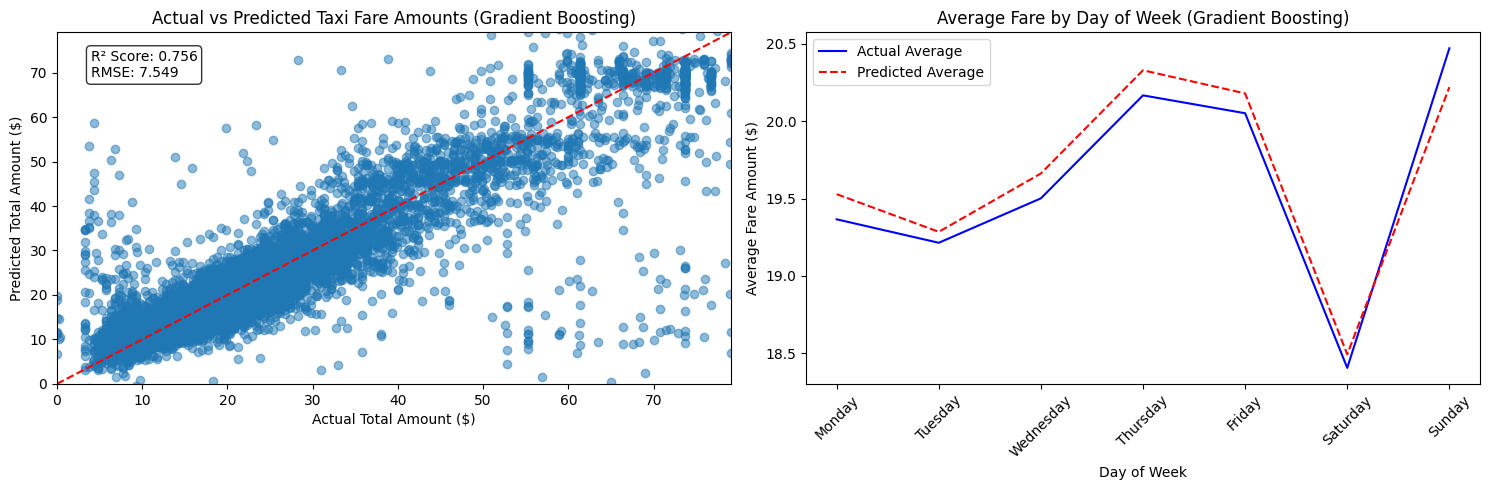


Feature Importances:
day_cos: 0.4947
dropoff_location_idx: 0.1587
pickup_location_idx: 0.1431
pickup_hour: 0.1030
day_sin: 0.0415
passenger_count: 0.0371
trip_distance: 0.0219


In [ ]:
# Define the GBT Regressor
# Modified GBTRegressor with adjusted parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="total_amount",
    maxDepth=6,           # Reduced to prevent overfitting
    maxBins=32,
    stepSize=0.1,
    maxIter=50,          # Reduced to speed up training
    minInstancesPerNode=5,
    subsamplingRate=0.8,
    lossType="squared",
    seed=42
)

# Run cross-validation to find the best model
model = gbt.fit(train_data)

# Make predictions using the best model
predictions = model.transform(test_data)

# Calculate metrics
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")
r2 = evaluator.setMetricName("r2").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)

# Create visualizations (same as before)
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Plot
plt.subplot(1, 2, 1)

# Calculate the max value for axis limits (80% of maximum)
pred_pd = predictions.select("total_amount", "prediction").toPandas()
max_value = max(pred_pd["total_amount"].max(), pred_pd["prediction"].max())
axis_limit = 0.2 * max_value

# Create scatter plot with modified axes
plt.scatter(pred_pd["total_amount"], pred_pd["prediction"], alpha=0.5)
plt.plot([0, axis_limit], [0, axis_limit], 'r--')  # Perfect prediction line
plt.xlim(0, axis_limit)
plt.ylim(0, axis_limit)
plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (Gradient Boosting)")
metrics_text = f'R² Score: {r2:.3f}\nRMSE: {rmse:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg = predictions.groupBy("pickup_day_of_week").agg({"total_amount": "avg", "prediction": "avg"}).toPandas()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.set_index('pickup_day_of_week').reindex(days_order)
plt.plot(day_avg.index, day_avg['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg.index, day_avg['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week (Gradient Boosting)")
plt.legend()
plt.tight_layout()
plt.show()

# Print feature importances
feature_names = ["pickup_hour", "day_sin", "day_cos", "passenger_count",
                "trip_distance", "pickup_location_idx", "dropoff_location_idx"]
importances = [(feature, abs(importance)) for feature, importance in zip(feature_names, model.featureImportances)]
importances.sort(key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature}: {importance:.4f}")

The performance of Gradiant Boosted Model is OK with R2 socre=0.756 and RMSE=7.549. It takes long to train even after feature reduction.

##Conclusion

Model Performance:

1. The performance of SVM model is the best with R2 Socre = 0.810 and RMSE=6.473. It's also very fast to train.
2. The performance of Ridge Regression is OK with R2 socre=0.767 and RMSE=7.455. It's also fast to train.
3. The performance of Random Forest Model is not so good with R2=0.709 and RMSE=8.287. It takes very long to train and the result distribution is not smooth.
4. The performance of Gradiant Boosted Model is OK with R2 socre=0.756 and RMSE=7.549. It takes long to train even after feature reduction.

SVM model is recommended to solve our problem.

Business Analysis:
The highest average cost of trip happends on Sunday and the lowest happends on Saturday. The business model can be tuned to encourage driver to work on Sunday and less on Saturday.